In [1]:
import numpy as np
import numpy
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [12]:
# import tensorflow as tf
# from tensorflow.python.client import timeline

# def model():
#     g = tf.Graph()
#     with g.as_default():
#         a = tf.random_normal([20, 50])
#         b = tf.random_normal([50, 10])
#         res = tf.matmul(a, b, name='res')
#     return g

# g = model()

# tmp = tf.profiler.profile(g, cmd='op')
# # with tf.Session() as sess:
# #     # add additional options to trace the session execution
# #     options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
# #     run_metadata = tf.RunMetadata()
# #     sess.run(res, options=options, run_metadata=run_metadata)

# #     # Create the Timeline object, and write it to a json file
# #     fetched_timeline = timeline.Timeline(run_metadata.step_stats)
# #     chrome_trace = fetched_timeline.generate_chrome_trace_format()
# #     with open('timeline_01.json', 'w') as f:
# #         f.write(chrome_trace)

In [ ]:
# # Create options to profile the time and memory information.
# builder = tf.profiler.ProfileOptionBuilder
# opts = builder(builder.time_and_memory()).order_by('micros').build()
# # Create a profiling context, set constructor argument `trace_steps`,
# # `dump_steps` to empty for explicit control.
# with tf.contrib.tfprof.ProfileContext('./tmp/train_dir',
#                                       trace_steps=[],
#                                       dump_steps=[]) as pctx:
#     with tf.Session(graph=g) as sess:
#         # Enable tracing for next session.run.
#         pctx.trace_next_step()
#         # Dump the profile to '/tmp/train_dir' after the step.
#         pctx.dump_next_step()
#         _ = sess.run(g.get_tensor_by_name('res:0'))
#         pctx.profiler.profile_operations(options=opts)

In [3]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config


# PM

In [6]:
pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=400, nc=128, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)


In [15]:
# tf.reset_default_graph()

# linear = tfpm.linfield(config)
# lineark = tfpf.r2c3d(linear, config)
# icstate = tfpm.lptinit(lineark, grid, config)
# final = tf.zeros_like(linear)
# final = tfpf.cic_paint(final, icstate[0], boxsize=bs)

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     linmesh, finmesh, fstate = sess.run([linear, final, icstate])


In [16]:
tf.reset_default_graph()

linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=True)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    linmesh, finmesh, fstate = sess.run([linear, final, fnstate])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


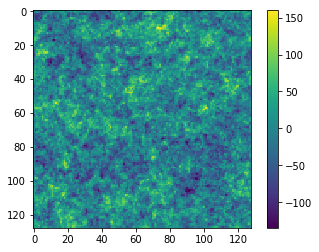

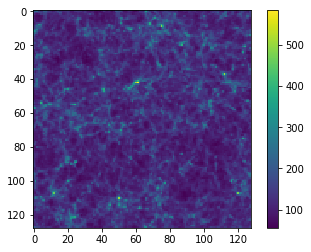

In [17]:
im = plt.imshow(linmesh.sum(axis=0))
plt.colorbar(im)
plt.show()
im = plt.imshow(finmesh.sum(axis=0))
plt.colorbar(im)
plt.show()


# Reconstruction

### Generate Data

In [29]:
#Generate DATA

pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)


tf.reset_default_graph()

linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=True)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    truth, data = sess.run([linear, final])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


In [19]:
#Generate DATA

tf.reset_default_graph()

linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=True)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
gradient = tf.gradients(final, linear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    truth, data, grad = sess.run([linear, final, gradient])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


In [11]:
# grad

## Try recon

In [31]:
tf.reset_default_graph()

kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh)
# priorwt

linear = tf.get_variable('linmesh', shape=(nc, nc, nc), initializer=tf.random_normal_initializer(), trainable=True)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=False)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#

priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior = tf.reduce_sum(tf.multiply(priormesh, priorwt))
prior = tf.multiply(prior, 1/nc**3)

sigma = 0.01**0.5

residual = tf.subtract(final, data)
residual = tf.multiply(residual, 1/sigma)

Rsm = tf.placeholder(tf.float32, name='smoothing')

Rsm = tf.multiply(Rsm, bs/nc)
Rsmsq = tf.multiply(Rsm, Rsm)
smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
residualk = tfpf.r2c3d(residual, config)
residualk = tf.multiply(residualk, tf.cast(smwts, tf.complex64))
residual = tfpf.c2r3d(residualk, config)
chisq = tf.multiply(residual, residual)
chisq = tf.reduce_sum(chisq)
chisq = tf.multiply(chisq, 1/nc**3)

# chisq = tf.losses.mean_squared_error(final, data, weights=1/sigma)

loss = tf.add(chisq, prior)



lr = tf.placeholder(tf.float32, name='learningrate')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss, var_list=[linear])
# opt_op = optimizer.minimize(loss)

niter = 3000
lr0 = 50
nlr, lrfac = 500, 2
nprint = 100
R0 = 4.

with tf.Session() as sess:
    losses = []
    sess.run(tf.global_variables_initializer())
    l, init = sess.run([loss, linear], {Rsm:0.})
    losses.append(l)
    #
    start, curr = time(), time()
    
    lp = l
    for it in range(niter+1):
#         print(it)
        _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, Rsm:R0})

        if it % nlr == 0:
            lr0 /= lrfac
            print('reduce learning rate by factor of %0.2f. New learning rate = %0.2e'%(lrfac, lr0))

        #Anneal
        if (R0 > 0) and (abs(l-lp)/lp < 0.001):
            R0 /= 2
            print('reduced R0 to : ', R0)
        lp = l
        if R0 and R0 < 0.5: 
            R0 = 0
            print('R0 = 0')
        if it % nprint == 0:
            end = time()
            print('Iter %d of %d : Loss= %0.4f\nTime taken for last batch = %0.3f, \
            \nTotal time elapsed = %0.3f'%(it, niter, l, end-curr, end - start))
            curr = end


        losses.append(l)

    recon = sess.run(linear)


reduce learning rate by factor of 2.00. New learning rate = 2.50e+01
Iter 0 of 3000 : Loss= 289.3323
Time taken for last batch = 0.563,             
Total time elapsed = 0.563
reduced R0 to :  2.0
Iter 100 of 3000 : Loss= 436.8737
Time taken for last batch = 23.842,             
Total time elapsed = 24.405
reduced R0 to :  1.0
Iter 200 of 3000 : Loss= 990.3827
Time taken for last batch = 24.043,             
Total time elapsed = 48.448
Iter 300 of 3000 : Loss= 1116.2893
Time taken for last batch = 23.748,             
Total time elapsed = 72.196
Iter 400 of 3000 : Loss= 911.0302
Time taken for last batch = 23.822,             
Total time elapsed = 96.018
reduce learning rate by factor of 2.00. New learning rate = 1.25e+01
Iter 500 of 3000 : Loss= 1008.8607
Time taken for last batch = 24.054,             
Total time elapsed = 120.072
reduced R0 to :  0.5
Iter 600 of 3000 : Loss= 1157.6394
Time taken for last batch = 23.747,             
Total time elapsed = 143.819
Iter 700 of 3000 : Lo

Text(0.5, 1.0, 'Recon')

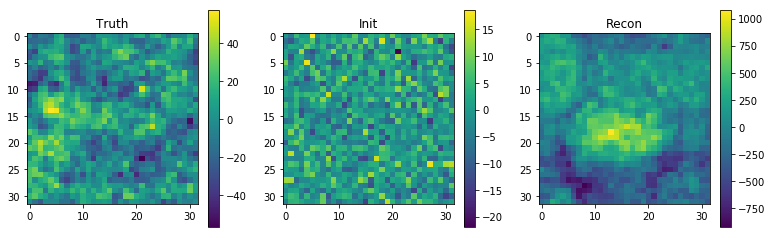

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(init.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Init')
im = ax[2].imshow(recon.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Recon')



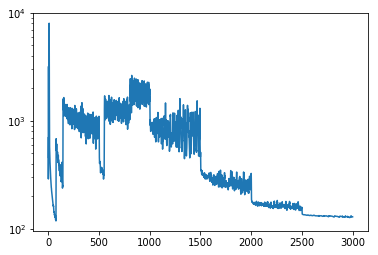

In [33]:
plt.plot(losses)
plt.yscale('log')

In [34]:
k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+init, boxsize=bs)
k, pr = tools.power(1+recon, boxsize=bs)
k, px = tools.power(1+truth, 1+recon, boxsize=bs)

[]

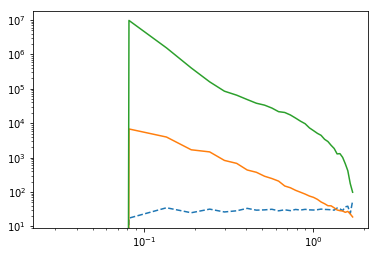

In [35]:
plt.plot(k, pi, '--')
plt.plot(k, pt)
plt.plot(k, pr)
plt.loglog()

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


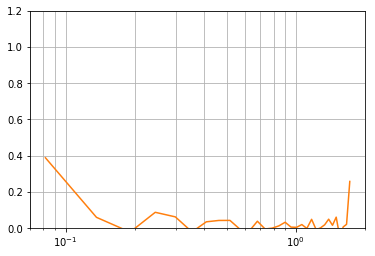

In [36]:
plt.plot(k, pr/pt)
plt.plot(k, px/(pr*pt)**.5)
plt.xscale('log')
plt.ylim(0.0, 1.2)
plt.grid(which='both')

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


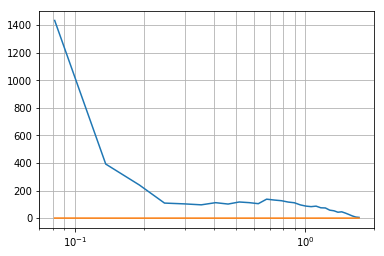

In [37]:
plt.plot(k, pr/pt)
plt.plot(k, px/(pr*pt)**.5)
plt.xscale('log')
# plt.ylim(0.5, 1.5)
plt.grid(which='both')

In [268]:
#

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


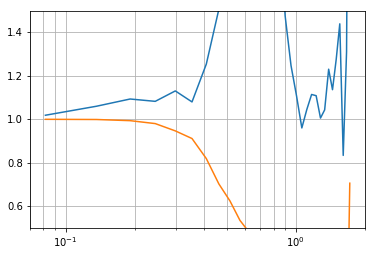

In [69]:
plt.plot(k, pr/pt)
plt.plot(k, px/(pr*pt)**.5)
plt.xscale('log')
plt.ylim(0.5, 1.5)
plt.grid(which='both')

# Check

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


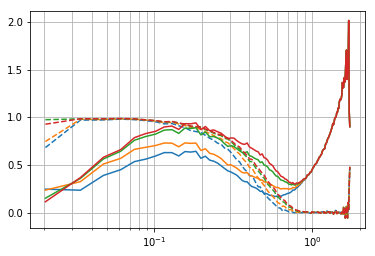

In [12]:
infolder = '../code/recon/L0400_N0128_S0100//'
bs, nc = 400, 128
truemesh = np.load(infolder + 'linear.f4.npy')
k, pt = tools.power(1+truemesh, boxsize=bs)
for j, it in enumerate([1000, 2000, 4000, 7000]):
    reconmesh = np.load(infolder + 'recon_%04d.f4.npy'%it)

    k, pr = tools.power(1+reconmesh, boxsize=bs)
    k, px = tools.power(1+truemesh, 1+reconmesh, boxsize=bs)
    plt.plot(k, pr/pt, 'C%d'%j)
    plt.plot(k, px/(pr*pt)**.5, 'C%d--'%j)
plt.xscale('log')
# plt.ylim(0.5, 1.5)
plt.grid(which='both')

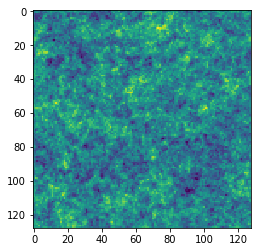

In [7]:
plt.imshow(truemesh.sum(axis=0))

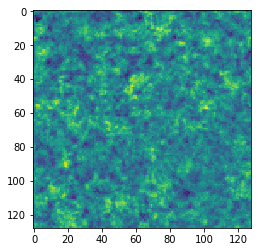

In [8]:
plt.imshow(reconmesh.sum(axis=0))

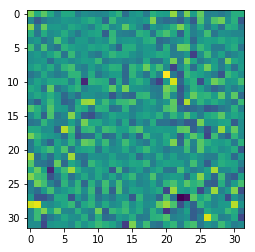

In [69]:
plt.imshow((truemesh-reconmesh).sum(axis=0))

# Profile

In [41]:
# pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=32, seed=100, stages = np.linspace(0.01, 1, 3), pkfile=pkfile)
# bs, nc = config['boxsize'], config['nc']
# grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)

# tf.reset_default_graph()
# def flowpm(config):
#     g = tf.Graph()
#     with g.as_default():
#         linear = tfpm.linfield(config)
#         lineark = tfpf.r2c3d(linear, config)
#         icstate = tfpm.lptinit(lineark, grid, config)
#         fnstate = tfpm.nbody(icstate, config, verbose=False)
#         final = tf.zeros_like(linear)
#         final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#     return g

# pmgraph = flowpm(config)

In [60]:
pkfile = '../code/flowpm/Planck15_a1p00.txt'
# config = Config(bs=100, nc=128, seed=100, stages = np.linspace(0.01, 1, 3), pkfile=pkfile)
config = Config(bs=100, nc=128, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)

tf.reset_default_graph()
linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=False)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ic, mesh = sess.run([icstate, final])


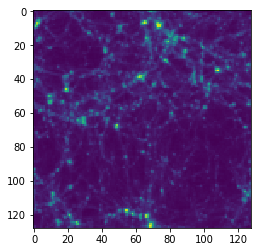

In [61]:
plt.imshow(mesh.sum(axis=0))

In [6]:
from time import time

In [55]:
%timeit tfpf.laplace(config)
%timeit tfpf.laplace2(config)
%timeit tfpf.gradient(config, 1)

19.9 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.4 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
ic[0]

array([[ 4.7943942e-02, -1.7028974e-03,  6.7412019e-02],
       [ 4.3343827e-02, -7.0656775e-03,  3.1618800e+00],
       [ 6.9417059e-02, -7.3283422e-03,  6.2857866e+00],
       ...,
       [ 9.6902298e+01,  9.6875732e+01,  9.0616890e+01],
       [ 9.6874756e+01,  9.6856544e+01,  9.3798386e+01],
       [ 9.6868729e+01,  9.6846260e+01,  9.6938789e+01]], dtype=float32)

In [45]:
tf.reset_default_graph()

niter = 100 

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_paint(tmesh, tpart,  boxsize=bs)

times = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for CIC - ', end - start, (totend-totstart)/niter)
np.array(times).mean(), np.array(times[1:]).mean()

Time taken for CIC -  0.0025892257690429688 0.0024735212326049806


(0.0024716901779174806, 0.0023616010492498226)

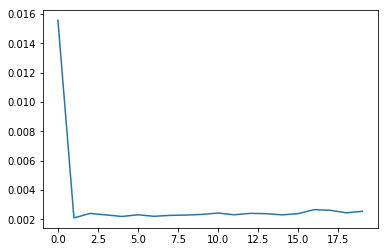

In [47]:
# plt.hist(times)
plt.plot(times)

In [48]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_readout(tmesh, tpart, boxsize=bs)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(result)
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 readouts - ', end - start, (end-start)/niter)

0.06261467933654785 0.0031307339668273926
Time taken for 100 readouts -  0.06261467933654785 0.0031307339668273926


In [23]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
tpart = tf.Variable(0.)
tpart = tf.assign(tpart, ic[0], validate_shape=False)
result = tfpf.cic_readout(tmesh, tpart, boxsize=bs)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(result)
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 readouts - ', end - start, (end-start)/niter)

6.238195419311523 0.31190977096557615
Time taken for 100 readouts -  6.238195419311523 0.31190977096557615


In [24]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh)
# tmesh = tf.cast(tmesh, tf.complex64)
result = tfpf.r2c3d(tmesh, config)

times = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    totstart = time()
    for _ in range(niter):
        start = time()
        sess.run(result)
        end = time()
        times.append(end - start)
    totend = time()
print('Time taken for r2c - ', end - start, (totend-totstart)/niter)

Time taken for r2c -  0.002867460250854492 0.02993224859237671


In [25]:
tf.reset_default_graph()

tmesh = tf.zeros_like(mesh, dtype=tf.complex64)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    start = time()
    for _ in range(niter):
        sess.run(tfpf.c2r3d(tmesh, config))
    end = time()
    print(end - start, (end-start)/niter)
print('Time taken for 100 c2r - ', end - start, (end-start)/niter)

12.759227991104126 0.6379613995552063
Time taken for 100 c2r -  12.759227991104126 0.6379613995552063


N = 32, CIC = 0.166, r2c = 0.018

N = 64, CIC = 0.8, r2c = 0.07